In [1]:
from firedrake import *

In [2]:
from contexttimer import Timer
import matplotlib.pyplot as plt
import scipy.interpolate as si
import scipy.optimize as so

In [3]:
from adapt_utils.case_studies.tohoku.options.options import TohokuInversionOptions
from adapt_utils.misc import gaussian, ellipse

In [4]:
class OptimisationProgress(object):
    def __init__(self):
        self.m_progress = []
        self.J_progress = []
        self.dJdm_progress = []
        self.ls_iteration = 0
        self.feval = 0
        self.geval = 0

In [5]:
OP = OptimisationProgress()

Specify 'optimum' and initial guess

In [6]:
m_opt = 5.0
m_prior = 10.0

Create `Options` object and setup gauges.

In [7]:
level = 2
op = TohokuInversionOptions(level=level)
gauges = list(op.gauges.keys())
for gauge in gauges:
    if gauge[:2] not in ('P0', '80'):
        op.gauges.pop(gauge)
gauges = list(op.gauges.keys())

/home/joe/software/firedrake-pragmatic/src/firedrake/firedrake/parloops.py:130: LoopyWarning: 'lang_version' was not passed to make_function(). To avoid this warning, pass lang_version=(2018, 2) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2' in the global scope of the calling frame.)
  knl = loopy.make_function(kernel_domains, instructions, kargs, seq_dependencies=True,


Setup timestepping parameters

In [8]:
num_timesteps = 30*2**level
dt = Constant(op.dt)
theta = Constant(0.5)

Create function spaces

In [9]:
mesh = op.default_mesh
P2 = VectorFunctionSpace(mesh, "CG", 1)
P1 = FunctionSpace(mesh, "CG", 1)
V = P2*P1
R = FunctionSpace(mesh, "R", 0)

Create `Function`s

In [10]:
u, eta = TrialFunctions(V)
test_u, test_eta = TestFunctions(V)
m = Function(R).assign(m_prior)
q0 = Function(V)
u0, eta0 = q0.split()
eta0.interpolate(gaussian([(0.7e+06, 4.2e+06, 48e+03, 96e+03)], mesh, rotation=pi/12))
q_ = Function(V)
u_, eta_ = q_.split();

Set physical parameters

In [11]:
b = Function(P1).assign(op.set_bathymetry(P1))
g = Constant(9.81)

Setup forward variational problem

In [12]:
a = inner(u, test_u)*dx + eta*test_eta*dx
a += theta*dt*g*inner(grad(eta), test_u)*dx - theta*dt*b*inner(u, grad(test_eta))*dx
L = inner(u_, test_u)*dx + eta_*test_eta*dx
L += -(1-theta)*dt*g*inner(grad(eta_), test_u)*dx + (1-theta)*dt*b*inner(u_, grad(test_eta))*dx
q = Function(V)
u, eta = q.split()
bc = DirichletBC(V.sub(1), 0, 100)
problem = LinearVariationalProblem(a, L, q, bcs=bc)

Setup forward variational solver

In [13]:
sp = {
    "snes_type": "ksponly",
    "ksp_type": "gmres",
    "pc_type": "fieldsplit",
    "pc_fieldsplit_type": "multiplicative",
}
solver = LinearVariationalSolver(problem, solver_parameters=sp)

In [14]:
# class NaiveSolver(object):
#     def __init__(self, lhs, rhs, sol, bcs, **kwargs):
#         self.lhs = lhs
#         self.rhs = rhs
#         self.sol = sol
#         self.bcs = bcs
#         self.kwargs = kwargs
    
#     def solve(self):
#         solve(self.lhs == self.rhs, self.sol, bcs=self.bcs, **self.kwargs)

In [15]:
# solver = NaiveSolver(a, L, q, bc, solver_parameters=sp)

Setup QoI

In [16]:
P0 = FunctionSpace(mesh, "DG", 0)
J_form = 0
radius = 20e+03*0.5**level
for gauge in gauges:
    op.gauges[gauge]["data"] = []
    k = Function(P0*P0)
    ku, keta = k.split()
    keta.interpolate(ellipse([op.gauges[gauge]["coords"] + (radius,)], mesh))
    keta.assign(keta/assemble(keta*dx))
    op.gauges[gauge]["indicator"] = keta
    op.gauges[gauge]["obs"] = Function(R)
    op.gauges[gauge]["obs_old"] = Function(R)
    J_form += theta*0.5*dt*keta*(eta - op.gauges[gauge]["obs"])**2*dx
    J_form += (1-theta)*0.5*dt*keta*(eta_ - op.gauges[gauge]["obs_old"])**2*dx

Solve forward to generate 'data'

In [17]:
u_.assign(u0)
eta_.project(m_opt*eta0)
for gauge in gauges:
    op.gauges[gauge]["data"].append(float(eta_.at(op.gauges[gauge]["coords"])))
for i in range(num_timesteps):
    print(f"t = {i*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")
    solver.solve()
    q_.assign(q)
    for gauge in gauges:
        op.gauges[gauge]["data"].append(float(eta.at(op.gauges[gauge]["coords"])))
print(f"t = {(i+1)*op.dt/60:5.1f} min  ||u|| = {norm(u):.4e}  ||eta|| = {norm(eta):.4e}")

t =   0.0 min  ||u|| = 0.0000e+00  ||eta|| = 0.0000e+00
t =   0.2 min  ||u|| = 1.4483e+03  ||eta|| = 4.2366e+05
t =   0.5 min  ||u|| = 2.8814e+03  ||eta|| = 4.2073e+05
t =   0.8 min  ||u|| = 4.2853e+03  ||eta|| = 4.1598e+05
t =   1.0 min  ||u|| = 5.6470e+03  ||eta|| = 4.0959e+05
t =   1.2 min  ||u|| = 6.9557e+03  ||eta|| = 4.0180e+05
t =   1.5 min  ||u|| = 8.2022e+03  ||eta|| = 3.9289e+05
t =   1.8 min  ||u|| = 9.3798e+03  ||eta|| = 3.8312e+05
t =   2.0 min  ||u|| = 1.0484e+04  ||eta|| = 3.7281e+05
t =   2.2 min  ||u|| = 1.1513e+04  ||eta|| = 3.6221e+05
t =   2.5 min  ||u|| = 1.2464e+04  ||eta|| = 3.5158e+05
t =   2.8 min  ||u|| = 1.3340e+04  ||eta|| = 3.4115e+05
t =   3.0 min  ||u|| = 1.4141e+04  ||eta|| = 3.3111e+05
t =   3.2 min  ||u|| = 1.4870e+04  ||eta|| = 3.2162e+05
t =   3.5 min  ||u|| = 1.5531e+04  ||eta|| = 3.1281e+05
t =   3.8 min  ||u|| = 1.6126e+04  ||eta|| = 3.0476e+05
t =   4.0 min  ||u|| = 1.6661e+04  ||eta|| = 2.9754e+05
t =   4.2 min  ||u|| = 1.7140e+04  ||eta|| = 2.9

Reduced functional

In [18]:
def rf(ctrl):
    m.assign(ctrl[0])
    OP.J = 0
    u_.assign(u0)
    eta_.project(m*eta0)
    OP.solutions = [q_.copy(deepcopy=True)]
    for i in range(num_timesteps):
        solver.solve()
        OP.solutions.append(q.copy(deepcopy=True))
        for gauge in gauges:
            op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
            op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
        OP.J = OP.J + assemble(J_form)
        q_.assign(q)
    return OP.J

Setup continuous adjoint variational problem and solver

In [19]:
phi = TestFunction(V)
cont_adj = Function(V)
z, zeta = cont_adj.split()
cont_adj_ = Function(V)
z_, zeta_ = cont_adj_.split()
a_star = adjoint(a)

In [20]:
w1 = Constant(1.0)
w2 = Constant(0.0)
L_star = replace(L, {test_u: z_, test_eta: zeta_, u_: test_u, eta_: test_eta})
for gauge in gauges:
    L_star += w1*theta*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx
    L_star += w2*(1-theta)*dt*op.gauges[gauge]["indicator"]*(eta - op.gauges[gauge]["obs"])*test_eta*dx

In [21]:
adj_problem = LinearVariationalProblem(a_star, L_star, cont_adj, bcs=bc)
adj_solver = LinearVariationalSolver(adj_problem, solver_parameters=sp)

In [22]:
# adj_solver = NaiveSolver(a_star, L_star, cont_adj, bc, solver_parameters=sp)

In [23]:
gc = eta0*zeta*dx - (1-theta)*dt*g*inner(grad(eta0), z)*dx
for gauge in gauges:
    op.gauges[gauge]['obs0'] = Function(R).assign(op.gauges[gauge]['data'][0])
    gc += dt*(1-theta)*op.gauges[gauge]['indicator']*(m*eta0 - op.gauges[gauge]['obs0'])*eta0*dx

Function to evaluate gradient

In [24]:
def gradient(ctrl):
    m.assign(ctrl[0])
    OP.m = ctrl[0]
    cont_adj_.assign(0.0)
    w2.assign(0.0)
    for i in range(num_timesteps-1, -1, -1):
        if i == num_timesteps-2:
            w2.assign(1.0)
        for gauge in gauges:
            op.gauges[gauge]["obs"].assign(op.gauges[gauge]["data"][i+1])
            op.gauges[gauge]["obs_old"].assign(op.gauges[gauge]["data"][i])
        q.assign(OP.solutions[i+1])
        q_.assign(OP.solutions[i])
        adj_solver.solve()
        cont_adj_.assign(cont_adj)
    OP.dJdm = assemble(gc)
    return OP.dJdm

In [25]:
def cb(ctrl):
    OP.ls_iteration += 1
    print(f"{OP.ls_iteration:4d}  {OP.m:7.4}  {OP.J:.8}  {OP.dJdm:.8}")
    OP.m_progress.append(OP.m)
    OP.J_progress.append(OP.J)
    OP.dJdm_progress.append(OP.dJdm)

In [26]:
OP.__init__()
with Timer() as t:
    out = so.fmin_bfgs(rf, 10.0, fprime=gradient, callback=cb, full_output=True)
m_opt, J_opt, dJdm_opt, B_opt, feval, geval, warn = out
print(f"CPU time: {t}s, {feval} function evaluations, {geval} gradient evaluations, {OP.ls_iteration} line searches")

   1     8.99  3901.0899  1786.1037
   2    6.697  956.175  782.95454
   3    4.908  255.67785  1.9804559e-05
   4    4.908  255.67785  9.0280433e-06
Optimization terminated successfully.
         Current function value: 255.677847
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
CPU time: 1091.203s, 5 function evaluations, 5 gradient evaluations, 4 line searches


In [27]:
print(f"Approximate Hessian: {1/B_opt[0][0]:.4f}")

Approximate Hessian: 437.5591


## Performance

`solve` (Naive)

|      Mesh      | feval | geval | LS |   Run 1   |   Run 2   |   Run 3   |   Run 4   |  Average  |
| -------------- | ----- | ----- | -- | --------- | --------- | --------- | --------- | --------- |
| $\mathcal H_0$ |   4   |   4   |  3 |   21.916  |   25.966  |   22.355  |   21.973  |   23.053  |
| $\mathcal H_1$ |   5   |   5   |  4 |  148.415  |  153.655  |  154.318  |  150.071  |  151.610  |
| $\mathcal H_2$ |   5   |   5   |  4 | 1154.650  | 1123.264  | 1074.954  | 1091.203  | 1111.000  |

`LinearVariationalSolver`

|      Mesh      | feval | geval | LS |   Run 1   |   Run 2   |   Run 3   |   Run 4   |  Average  |
| -------------- | ----- | ----- | -- | --------- | --------- | --------- | --------- | --------- |
| $\mathcal H_0$ |   4   |   4   |  3 |   11.700  |   10.244  |   10.131  |   10.140  |   10.554  |
| $\mathcal H_1$ |   5   |   5   |  4 |   84.672  |   81.813  |   81.788  |   82.015  |   82.572  |
| $\mathcal H_2$ |   5   |   5   |  4 |  623.400  |  627.681  |  616.115  |  618.146  |  633.840|

In [28]:
l = si.lagrange(OP.m_progress[:3], OP.J_progress[:3])
dl = l.deriv()
l_min = -dl.coefficients[1]/dl.coefficients[0]
print(f"Minimiser of quadratic: {l_min:.4f}")
print(f"Exact Hessian: {dl.coefficients[0]:.4f}")

Minimiser of quadratic: 4.9080
Exact Hessian: 437.5592


Plot progress of optimisation

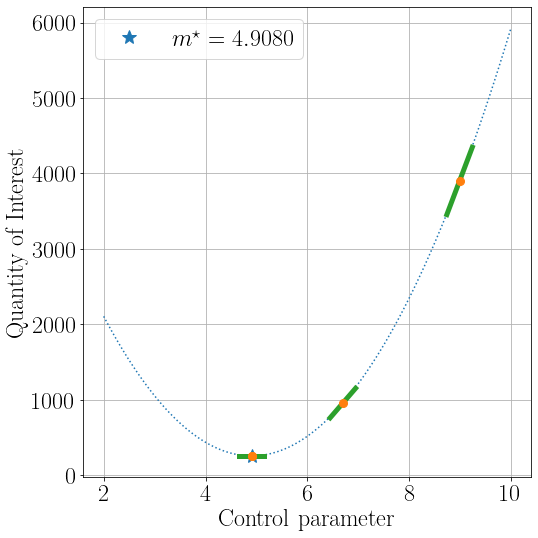

In [29]:
fig, axes = plt.subplots(figsize=(8, 8))
xx = np.linspace(2, 10, 100)
axes.plot(xx, l(xx), ':', color='C0')
axes.plot(l_min, l(l_min), '*', markersize=14, color='C0', label=r"$m^\star={:.4f}$".format(l_min))

delta_m = 0.25
for i, (mi, fi, gi) in enumerate(zip(OP.m_progress, OP.J_progress, OP.dJdm_progress)):
    x = np.array([mi - delta_m, mi + delta_m])
    axes.plot(x, gi*(x - mi) + fi, '-', color='C2', linewidth=5)
axes.plot(OP.m_progress, OP.J_progress, 'o', color='C1', markersize=8)

axes.set_xlabel("Control parameter")
axes.set_ylabel("Quantity of Interest")
axes.grid(True)
axes.legend()
plt.tight_layout()
plt.savefig(f"plots/tohoku1d_inversion_continuous_{level}.pdf")

Minimisers for $\theta=\frac12$: 4.0913, 4.5619, 4.9080.